In [333]:
%matplotlib inline
from __future__ import print_function
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.learning_curve import learning_curve
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from scipy import stats
import pickle
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning, append=True)
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
pd.set_option('mode.chained_assignment',None)

In [249]:
def get_score(y_pred, y):
    return np.sqrt(np.mean((y_pred - y)**2))

def draw_price_line(classid_list):
    clean_traindata = pickle.load(open('./output/train_data.bin','rb'))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    #plt.gcf().autofmt_xdate() 
    data = clean_traindata[['sale_date','class_id','sale_quantity']].sort_values('sale_date', axis=0, ascending=True)
    plt.rcParams['figure.figsize'] = (18,10)
    for class_id in classid_list:
        quantity = data.sale_quantity[data.class_id == class_id]
        xs = [datetime.strptime(d, '%Y%m').date() for d in data.sale_date[data.class_id == class_id].astype('str')]
        plt.plot(xs, quantity, label=class_id)
        plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.show()

In [245]:
lb = LabelEncoder()
data = pickle.load(open('./output/train_data.bin','rb'))
#for col in data.select_dtypes('object').columns:
#    data[col] = lb.fit_transform(data[col])
#data.drop('sale_date', axis=1, inplace=True)
data = data.drop_duplicates()

## 用 ARIMA 序列分析方法进行预测

In [360]:
pred_result = {'predict_date':[], 'class_id':[],'predict_quantity':[]}
for class_id in data.class_id.unique(): 
    train = data[['sale_date','sale_quantity']][data.class_id == class_id].set_index('sale_date')
    train.index = pd.to_datetime(train.index, format='%Y%m')
    train['sale_quantity'] = train.sale_quantity.astype('float64')
    pred_result['predict_date'].append(201711)
    pred_result['class_id'].append(class_id)
    try:
        pred, stder, conf_int = ARIMA(train, (0,1,1)).fit().forecast(1)
        pred_result['predict_quantity'].append(np.round(pred)[0])
    except ValueError as err:
        pred_result['predict_quantity'].append(int(train.iloc[-1,0]))
        
df_result = pd.DataFrame(pred_result, dtype='int')
df_result.to_csv('./output/yancheng-ARIMA-20180203-16.csv', index=False)
print(df_result.shape)
print(df_result.head(5))

(140, 3)
   class_id  predict_date  predict_quantity
0    103507        201711               211
1    124140        201711               272
2    125403        201711               156
3    136916        201711               161
4    169673        201711               223


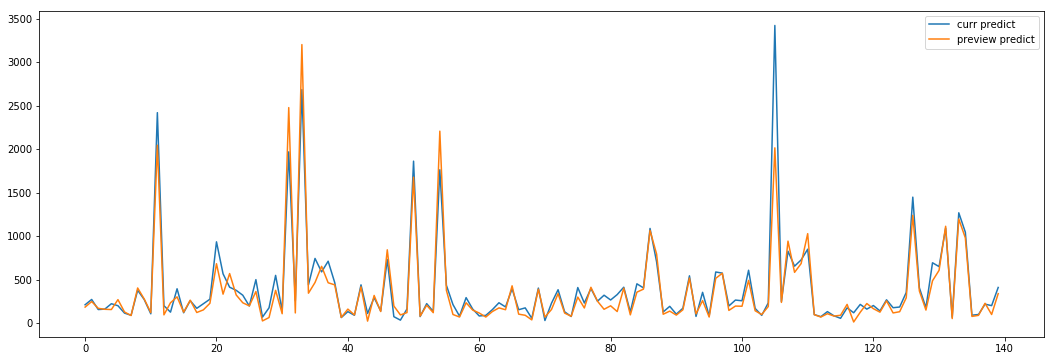

In [364]:
preview_df = pd.read_csv('./output/yancheng_mix-20180201_22.csv')
plt.plot(np.arange(140), df_result['predict_quantity'], label='curr predict')
plt.plot(np.arange(140), preview_df['predict_quantity'], label='preview predict')
plt.legend(loc='best')
plt.rcParams['figure.figsize'] = (18,6)

In [373]:
print(df_result.predict_quantity.max())
classid=735971
print(data['sale_quantity'][data.class_id == classid].describe())
print(df_result[df_result.class_id == classid])
data[['sale_date','sale_quantity']][data.class_id == classid]

3424
count      70.000000
mean     2037.228571
std       995.568066
min       490.000000
25%      1262.500000
50%      1690.000000
75%      2739.000000
max      4283.000000
Name: sale_quantity, dtype: float64
     class_id  predict_date  predict_quantity
105    735971        201711              3424


,sale_date,sale_quantity
117,201201,877
117,201202,490
117,201203,662
117,201204,688
117,201205,1024
117,201206,1247
117,201207,1282
117,201208,1358
117,201209,1092
117,201210,1497


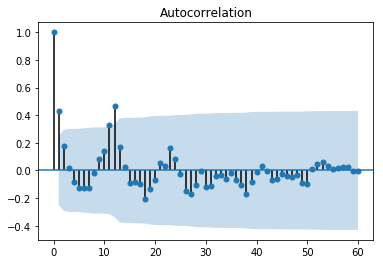

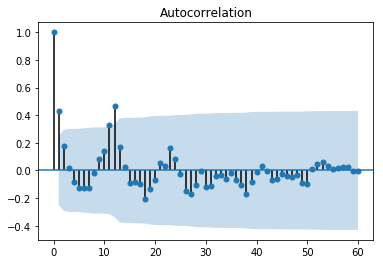

In [322]:
#自相关图
plot_acf(train)

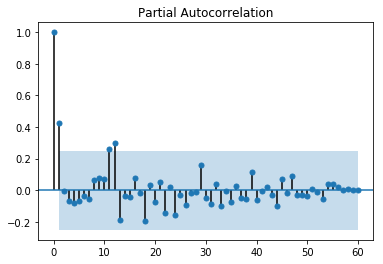

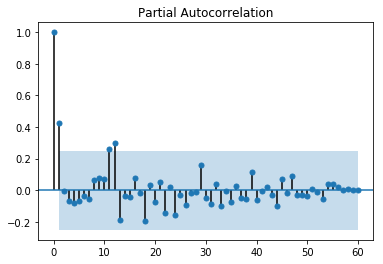

In [334]:
# 偏自相关性
plot_pacf(train)

In [323]:
#平稳性检测
##返回值依次为adf、pvalue、usedlag、nobs、critical values、icbest、regresults、resstore
print(u'原始序列的ADF检验结果为：', ADF(train['sale_quantity']))

原始序列的ADF检验结果为： (-2.664525444764245, 0.0803806362654686, 11, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, 837.5768608266064)


In [335]:
print(u'一阶序列的ADF检验结果为：', ADF(train.diff().dropna()['sale_quantity']))

一阶序列的ADF检验结果为： (-6.7194062336697, 3.5141529802623597e-09, 10, 49, {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}, 827.8332551579156)


In [337]:
print(u'差分序列的白噪声检验结果为：', acorr_ljungbox(train.diff().dropna()['sale_quantity'], lags=1)) 

差分序列的白噪声检验结果为： (array([5.22031922]), array([0.02232445]))


In [338]:
#定阶

#一般阶数不超过length/10
pmax = int(len(train)/10) 

#一般阶数不超过length/10

qmax = int(len(train)/10) 

#bic矩阵

bic_matrix = [] 
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
    #存在部分报错，所以用try来跳过报错。
        try: 
            tmp.append(ARIMA(train, (p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

#从中可以找出最小值
bic_matrix = pd.DataFrame(bic_matrix) 
print(bic_matrix)
#先用stack展平，然后用idxmin找出最小值位置。

p,q = bic_matrix.stack().idxmin() 

print(u'BIC最小的p值和q值为：%s、%s' %(p,q)) 


#取BIC信息量达到最小的模型阶数，结果p为0，q为1，定阶完成。


#建立ARIMA(0, 1, 1)模型

model = ARIMA(train, (p,1,q)).fit() 

#给出一份模型报告

print(model.summary2())
pred, stderr, conf_int = model.forecast(1)
print(pred)

             0            1     2     3     4     5     6
0  1088.508335  1040.778870  None  None  None  None  None
1  1067.099871          NaN  None  None  None  None  None
2  1061.435043          NaN  None  None  None  None  None
3  1060.814770          NaN  None  None  None  None  None
4  1062.040374  1049.577910  None  None  None  None  None
5  1063.052729  1052.411141  None  None  None  None  None
6  1066.131222  1055.817086  None  None  None  None  None


TypeError: reduction operation 'argmin' not allowed for this dtype

In [342]:
ARIMA(train,(0,1,1)).fit().forecast(1)

(array([2685.86677391]),
 array([1327.67036298]),
 array([[  83.68067913, 5288.0528687 ]]))

In [119]:
gdm = XGBRegressor(learning_rate=0.1, n_estimators=1000, n_jobs=-1, nthread=32,
              seed=0, max_depth=7,gamma=1.0, subsample=0.7)
lower_score_list = {}
pred_result = {'predicate_date':[], 'class_id':[],'predict_quantity':[],'score':[]}
for class_id in data.class_id.unique():
    subdata = data[data.class_id == class_id]
    y  = subdata['sale_quantity']
    subdata.drop('sale_quantity', axis=1, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(subdata, y, test_size=0.1, random_state=0)
    pred = gdm.fit(X_train, y_train).predict(X_test)
    score = get_score(pred, y_test)
    pred_data = subdata.head(1)
    pred_data['year'] = 2017
    pred_data['month'] = 11
    pred_y = gdm.predict(pred_data)
    pred_result['predicate_date'].append(201711)
    pred_result['class_id'].append(class_id)
    pred_result['predict_quantity'].append(np.round(pred_y[0]))
    pred_result['score'].append(int(score))
final_result = pd.DataFrame(pred_result).sort_values(['class_id'], axis=0, ascending=True)

In [120]:
final_result['m10_quantity'] = data['sale_quantity'][(data.year == 2017) & (data.month == 10)]

In [164]:
# final_result = pd.merge(final_result, 
#          data[['class_id','sale_quantity']][(data.year == 2017) & (data.month == 10)],
#          how='left',
#          on='class_id')

,class_id,predicate_date,predict_quantity,score,sale_quantity
0,103507,201711,393.0,234,180
1,124140,201711,372.0,107,263
2,125403,201711,153.0,11,156
3,125403,201711,153.0,11,156
4,136916,201711,171.0,85,162
5,169673,201711,153.0,131,152
6,175962,201711,286.0,219,237
7,178529,201711,167.0,83,148
8,186250,201711,220.0,53,83
9,194201,201711,239.0,139,378


In [176]:
final_result[np.abs(final_result.sale_quantity - final_result.predict_quantity) / final_result.sale_quantity > 0.8]

,class_id,predicate_date,predict_quantity,score,sale_quantity
0,103507,201711,393.0,234,180
8,186250,201711,220.0,53,83
14,219195,201711,294.0,16,125
15,219195,201711,294.0,16,125
19,248352,201711,518.0,260,260
38,348641,201711,1173.0,376,340
55,412240,201711,284.0,106,68
62,437598,201711,181.0,22,66
64,468392,201711,310.0,51,146
71,492952,201711,281.0,142,150


In [237]:
final_result['predict_quantity'] = final_result.predict_quantity.astype('int')
final_result[['predicate_date','class_id','predict_quantity']].to_csv('./output/yancheng_single_predict_2018020217.csv', index=False)

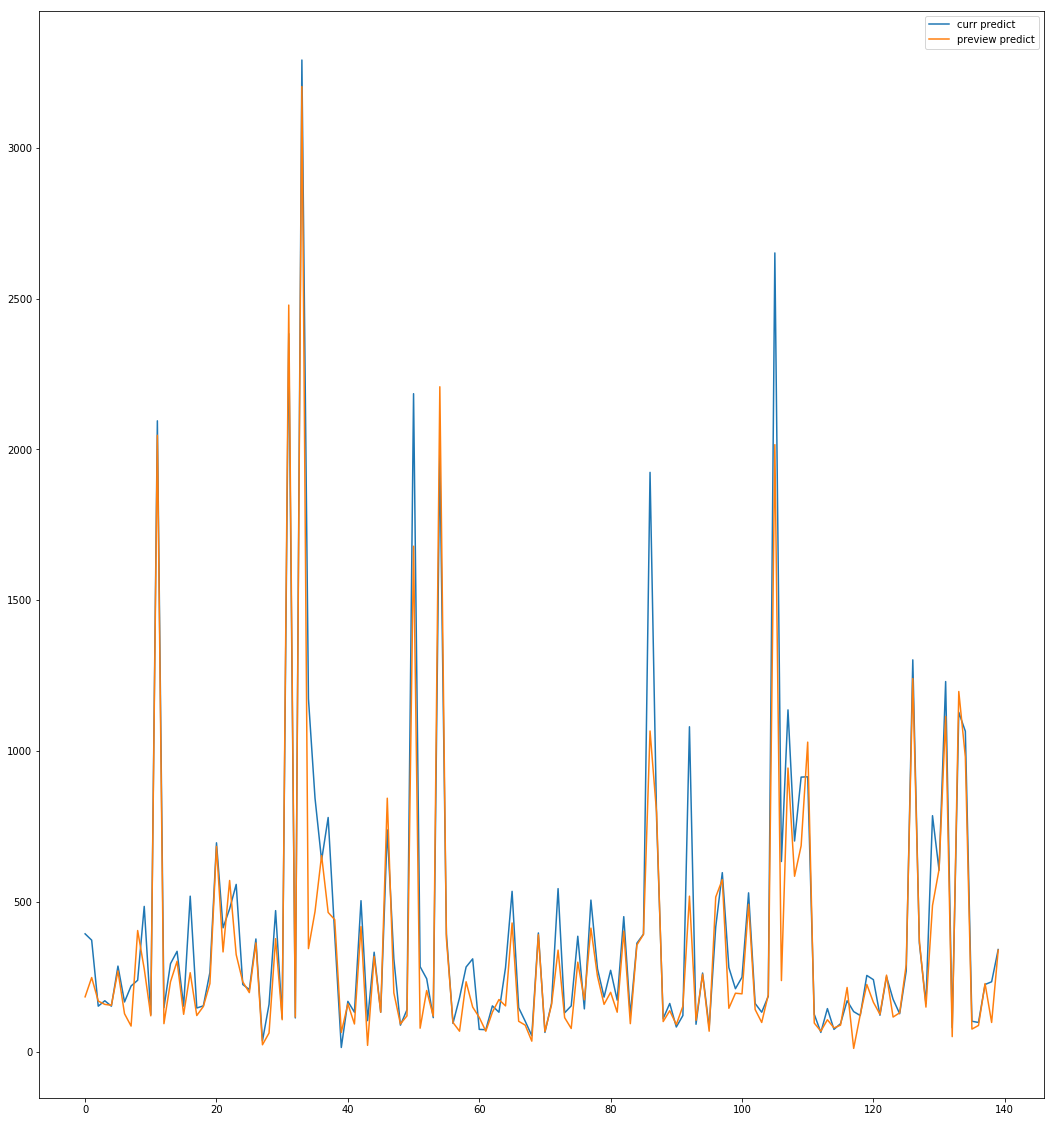

In [230]:
pre_pred = pd.read_csv('./output/yancheng_mix-20180201_22.csv')['predict_quantity'].values.reshape(-1,)
plt.plot(np.arange(140),final_result['predict_quantity'].values.reshape(-1,), label='curr predict')
#plt.plot(np.arange(140), final_result['sale_quantity'].values.reshape(-1,), label='m10')
plt.plot(np.arange(140), pre_pred, label='preview predict')
plt.rcParams['figure.figsize']=(18,20)
plt.legend(loc='best')
plt.show()

In [ ]:
df_data = pickle.load(open('./output/train_data.bin','rb'))

In [198]:
df_data[['sale_date','sale_quantity']][(df_data.class_id == 412240)]

,sale_date,sale_quantity
55,201605,47
55,201606,94
55,201607,172
55,201608,182
55,201609,291
55,201610,172
55,201611,218
55,201612,364
55,201701,286
55,201702,177
